
# Test clouds and skimage in a mountain range


### JAH, April 2021

In [203]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [204]:
import numpy             as np
import matplotlib.pyplot as plt

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges    as ridges

In [205]:
import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Apr 28 17:58:45 2021


## About the Ridge Detection

References:

* [Linderberg-98](http://kth.diva-portal.org/smash/record.jsf?pid=diva2%3A452310&dswid=812) and [Linderberg-08](),

* [Crowley-84](http://crowley-coutaz.fr//jlc/papers/Crowley-Parker84.pdf)

* [Sato-98](https://www.sciencedirect.com/science/article/pii/S1361841598800091) 3D Ridges


### Ridges In 2D

My definition:
A "Ridge" correspond to a line where locally the gradient coindides with one of the eigen-vectors of the hessianand the curvature in the ortogonal directions (u) to the gradient are negative (convex) and greather than the curvature in the gradient direction (v). 

in 2D:

$$
f_\phi = \cos \phi f_x + \sin \phi f_y \\
f_{\phi\phi} = \cos^2\phi f_{xx} + 2 \cos \phi \sin \phi f_{xy} + \sin^2 \phi f_{yy}
$$

The differential invariants:

$$
i) \; |\nabla f|^2 = f^2_x + f^2_y, \\
ii) \; \nabla^2 f = f_{xx} + f_{yy}, \\
ii) \mathrm{det}|H| = f_{xx} f_{yy} - 2 f_{xy}, \\
ii) \kappa(f) = f^2_x f_{yy} + f^2_x f_{xx} - 2 f_x f_y f_{xy}
$$

In the hessian eigen-vector (p, q) with p is the main eigen-direction of the hessian.

$$
f_p = 0, \; f_{pp} \le 0, \; |f_{pp}| \ge |f_{qq}|
$$

In the gradien basis (u, v), where v is the gradiant direction

$$
f_{uv} = 0, \; f_{uu} \le 0, |f_{uu}| \ge |f_{vv}|
$$

(*I understand this condition as the gradient direction as a minor eigen-direction of the hessian*)

### In the gradient basis

$$
{\bf e}_u = (\sin \phi, - \cos \phi), \; {\bf e}_v = (\cos \phi, \sin \phi), \; u \times v = k
$$

It translates to:

$$
f_{uu} = \sin^2 \phi f_{xx} - 2 \sin\phi \cos\phi f_{xy} + \cos^2 \phi f_{yy} \\
f_{vv} = \cos^2 \phi f_{xx} + 2 \sin\phi \cos\phi f_{xy} + \sin^2 \phi f_{yy} \\
f_{uv} = \cos\phi \sin\phi \, (f_{xx} - f_{yy}) - f_{xy} (\cos^2\phi - \sin^2 \phi) 
$$

The condition $f_{uv} = 0$ translates to:

$$
\tan 2 \phi = 2 \frac{f_{xx} - f_{yy}}{f_{xy}}
$$

### In the curvature basis

Definition of a ridge in terms of local differential geometry properties: a connect set of points where the intensity assumes a local maximum in the direction of the main curvature.

The conditions:

$$
f_p = 0, f_{pp} \lt 0, |f_{pp}| \gt  |f_{qq}|
$$

In this case, the rotation angle is giben by:

$$
\cos \beta = \sqrt{\frac{1}{2}\left( 1 + \frac{f_{xx} - f_{yy}}{\sqrt{(f_{xx} - f_{yy})^2 + 4 f_{xy}}} \right)}  \\
\sin \beta = \frac{f_{xy}}{|f_{xy}|}\sqrt{\frac{1}{2}\left( 1 - \frac{f_{xx} - f_{yy}}{\sqrt{(f_{xx} - f_{yy})^2 + 4 f_{xy}}} \right)}  \\
$$

The basis vector are:

$$
{\bf e}_p = (\sin \beta, -\cos \beta), \; {\bf e}_q = (\cos \beta, \sin \beta)
$$

## Generate sample

In [206]:
def generate_points(sizes, line = None, sigma = 1):
    
    size0   = np.min(sizes)
    npoints = len(sizes)
    ts = np.linspace(0, 1., npoints)
    ts = [ni * [ti,] for ni, ti in zip(sizes, ts)]
    ts.append(np.random.uniform(size = size0))
    ts = np.concatenate(ts)

    size = len(ts)
    iden = lambda x: x
    x, y = (iden, iden) if line is None else line
    xs   = x(ts) + sigma * np.random.normal(size = size)
    ys   = y(ts) + sigma * np.random.normal(size = size)
    
    return xs, ys

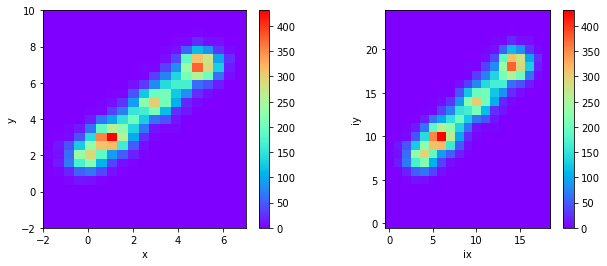

In [207]:
sizes = 1000 * np.array((2, 3, 1, 2, 1, 3))
scale, offset = 5, 2
line  = lambda x: scale * x,  lambda x: offset + scale * x
xs, ys = generate_points(sizes, line, sigma = 0.5)

size  = 2 
xbins = np.linspace(-2,  7, size * 10)
ybins = np.linspace(-2, 10, size * 13)

bins  = (xbins, ybins)
counts, _, _  = np.histogram2d(xs, ys, bins = bins)

plt.figure(figsize = (5 * 2, 1 * 4))
plt.subplot(1, 2, 1)
plt.hist2d(xs, ys, bins);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
plt.subplot(1, 2, 2)
plt.imshow(counts.T, origin = 'lower')
plt.xlabel('ix'); plt.ylabel('iy')
plt.colorbar();


In [208]:
#print(plt.rcParams.keys());

### Create clouds potential

steps  (0.4736842105263157, 0.48)


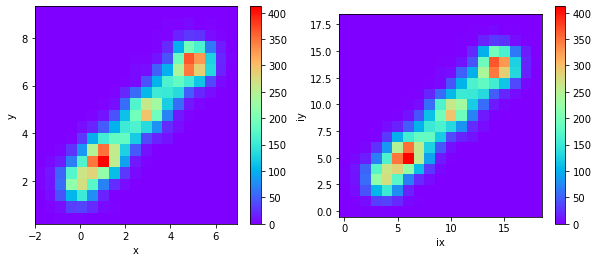

In [209]:
plt.rcParams['image.cmap'] = 'rainbow'
coors = (xs, ys)
ones  = np.ones(len(xs))
steps = (xbins[1]-xbins[0], ybins[1] - ybins[0])
print('steps ', steps)
bins, icells, cells, enes, kids = clouds.clouds_potential(coors, steps, ones)

counts, _, _ = np.histogram2d(*cells, bins = bins, weights = enes)

plt.figure(figsize = (2 * 5, 1 * 4))
plt.subplot(1, 2, 1)
plt.hist2d(*cells, bins = bins, weights = enes);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
plt.subplot(1, 2, 2)
plt.imshow(counts.T, origin = 'lower')
plt.xlabel('ix'); plt.ylabel('iy')
plt.colorbar();

#### Clouds gradient

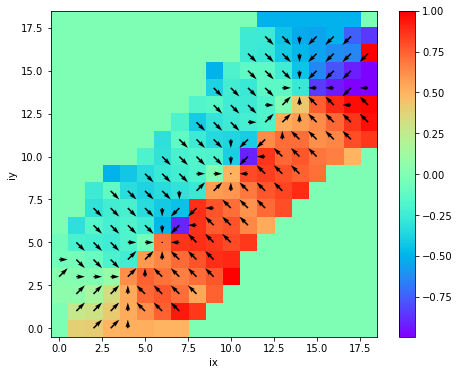

In [215]:
egrad, epath = clouds.clouds_gradient(bins, cells, enes, kids) 
plt.figure(figsize = (8, 6))
pltclouds.dcloud_grad(icells, epath)
lx, ly = np.gradient(counts)
phi = np.arctan2(ly, lx)/np.pi
plt.imshow(phi.T, origin = 'lower');
plt.xlabel('ix'); plt.ylabel('iy');
plt.colorbar();

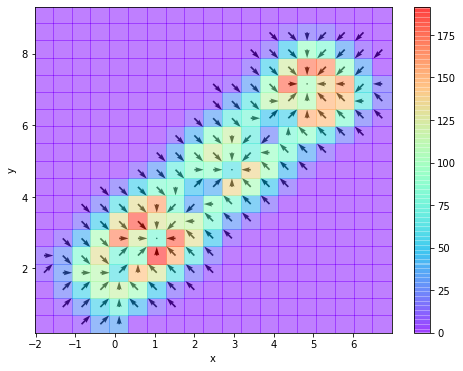

In [218]:
vgrad = clouds.clouds_vgrad(bins, cells, enes) 
plt.figure(figsize = (8, 6))
pltclouds.dcloud_grad(cells, epath)
plt.xlabel('x'); plt.ylabel('y')
plt.hist2d(*cells, bins, weights = vgrad.flatten(), alpha = 0.5)
plt.colorbar();

In [219]:
ngrad = clouds.clouds_neighbours_grad(bins, cells, kids, epath) 

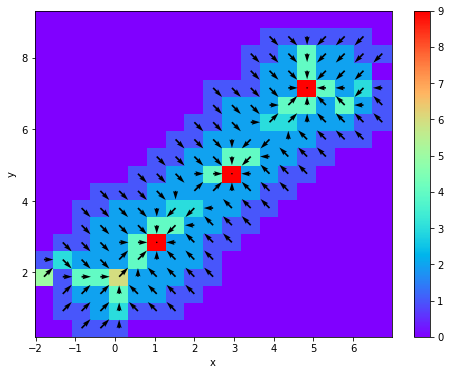

In [220]:
plt.figure(figsize = (1 * 8, 1 * 6))
plt.hist2d(*cells, bins = bins, weights = ngrad);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
pltclouds.dcloud_grad(cells, epath)

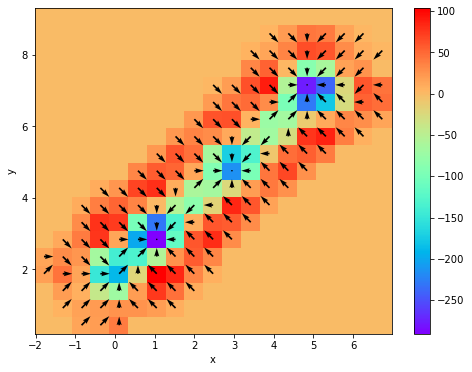

In [221]:
lapl = clouds.clouds_laplacian(bins, cells, enes) 
plt.figure(figsize = (1 * 8, 1 * 6))
plt.hist2d(*cells, bins = bins, weights = lapl);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
pltclouds.dcloud_grad(cells, epath)

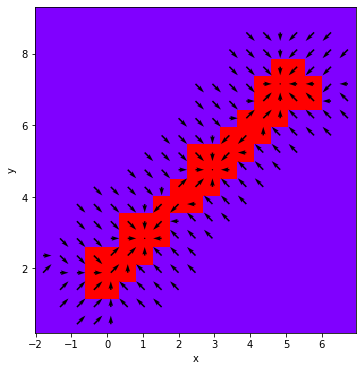

In [228]:
lapl = clouds.clouds_laplacian(bins, cells, enes) 
lapl[lapl >= 0] = 0
lapl[lapl < 0]  = 1
plt.figure(figsize = (1 * 8, 1 * 6))
plt.hist2d(*cells, bins = bins, weights = lapl);
plt.xlabel('x'); plt.ylabel('y')
#plt.colorbar();
pltclouds.dcloud_grad(cells, epath)
plt.gca().set_aspect('equal')

In [178]:
hess          = ridges.hessian(counts)
i0, i1, theta = ridges.hess2d_eigvals(hess)
lap           = ridges.laplacian(hess)
imin          = np.minimum(i0, i1)

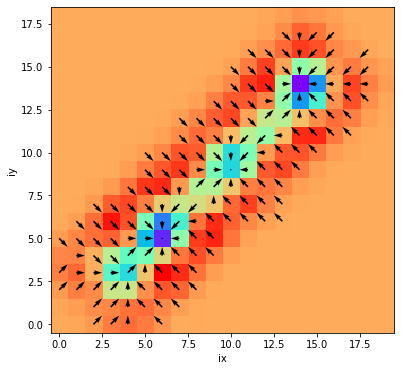

In [180]:
plt.figure(figsize = (1 * 8, 1 * 6))
plt.xlabel('ix'); plt.ylabel('iy')
pltclouds.dcloud_grad(icells, epath)
plt.imshow(lap.T, origin = 'lower');

**Note**:

    * For the Ridge we consider dispersive cells only! (laplacian < 0)

### About the passes

In [188]:
nodes, enodes, _    = clouds.clouds_nodes(enes, kids, epath)
lgrad, lnode, lpath = clouds.clouds_gradient_link(bins, cells, enes, nodes, kids)
epass  = clouds.clouds_passes(enes, nodes, enodes, lnode, kids, lgrad, lpath)

In [187]:
print(lpath == kids)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False  True  True  True  True  True
  True  True  True False False False  True  True  True  True  True  True
 False False False False  True  True  True  True  True  True False False
 False False  True  True  True  True False False False False  True  True
  True  True False False False  True  True  True  True False False False
  True  True  True  True  True  True False False False False  True  True
  True  True  True  True  True False False False  True  True  True  True
  True  True  True False False False  True  True  True  True  True False
 False False False  True  True  True  True  True False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


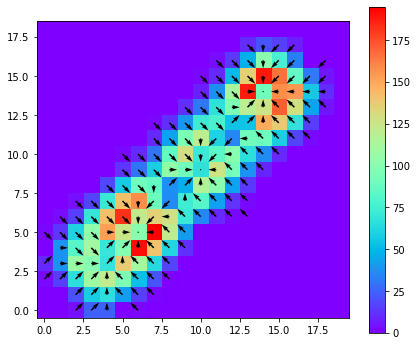

In [200]:
vgrad = clouds.clouds_vgrad(bins, cells, enes)

cc, _, _ = np.histogram2d(*cells, bins = bins, weights = vgrad);
plt.figure(figsize = (7, 6))
pltclouds.dcloud_grad (icells, epath)
plt.imshow(cc.T, origin = 'lower');
plt.colorbar();

In [181]:
lxx, lxy, lyy = hess[0, 0], hess[0, 1], hess[1, 1]
luu, luv, lvv, theta = hess_uv(lxx, lxy, lyy, phi * np.pi)

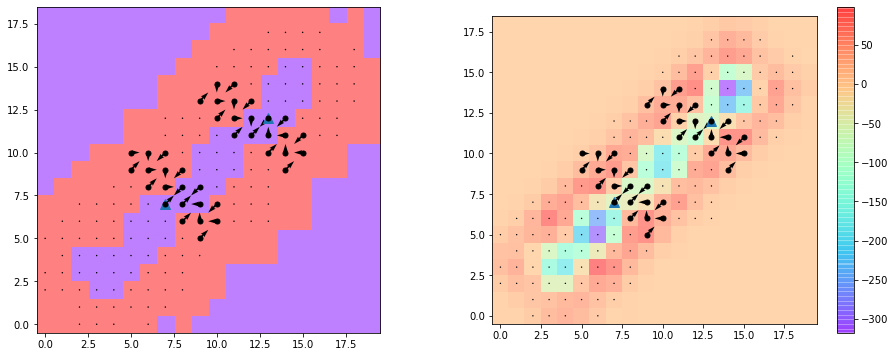

In [182]:
nodes, enodes, _    = clouds.clouds_nodes(enes, kids, epath)
lgrad, lnode, lpath = clouds.clouds_gradient_link(bins, cells, enes, nodes, kids)
epass  = clouds.clouds_passes(enes, nodes, enodes, lnode, kids, lgrad, lpath)

plt.figure(figsize = (2 * 8, 1 * 6))
plt.subplot(1, 2, 1)
pltclouds.dcloud_grad (icells, lpath)
plt.imshow(dissel.T, origin = 'lower', alpha = 0.5);
isel   = epass > 0
plt.plot(*csel_(icells, isel), marker = '^', ls = '', ms = 10)
isel = (lnode > 0) & (nodes != lnode)
plt.plot(*csel_(icells, isel), marker = 'o', color ='black', ls = '', ms = 5)
#plt.colorbar();

plt.subplot(1, 2, 2)
pltclouds.dcloud_grad (icells, lpath)
usel = lap
plt.imshow(usel.T, origin = 'lower', alpha = 0.5);
isel   = epass > 0
plt.plot(*csel_(icells, isel), marker = '^', ls = '', ms = 10)
isel = (lnode > 0) & (nodes != lnode)
plt.plot(*csel_(icells, isel), marker = 'o', color ='black', ls = '', ms = 5)
plt.colorbar();

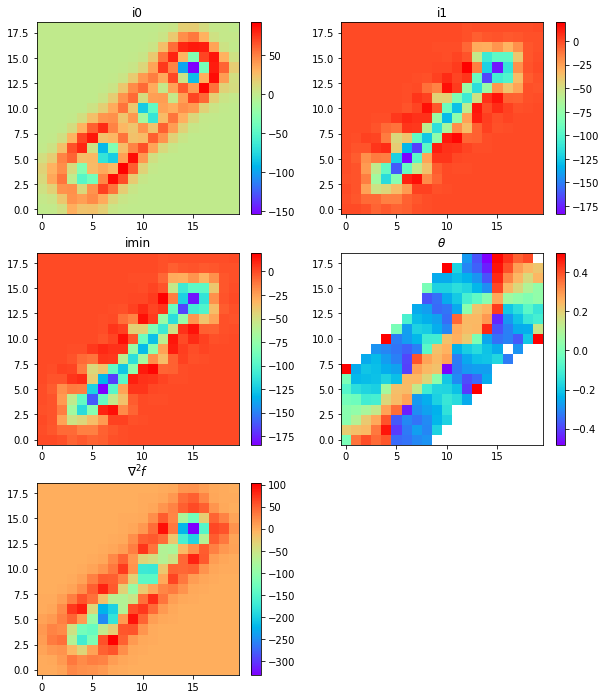

In [65]:
plt.figure(figsize = (2 * 5, 3 * 4))

plt.subplot(3, 2, 1)
plt.imshow(i0.T, origin = 'lower');
plt.colorbar();
plt.title('i0')
plt.subplot(3, 2, 2)
plt.imshow(i1.T, origin = 'lower');
plt.title('i1')
plt.colorbar();
plt.subplot(3, 2, 3)
plt.imshow(imin.T, origin = 'lower');
plt.colorbar();
plt.title('imin')
plt.subplot(3, 2, 4)
plt.imshow(theta.T, origin = 'lower');
plt.title(r'$\theta$')
plt.colorbar();
plt.subplot(3, 2, 5)
plt.imshow(lap.T, origin = 'lower');
plt.colorbar();
plt.title(r'$\nabla^2 f$');

#### Relation between the gradient and the curvature axis

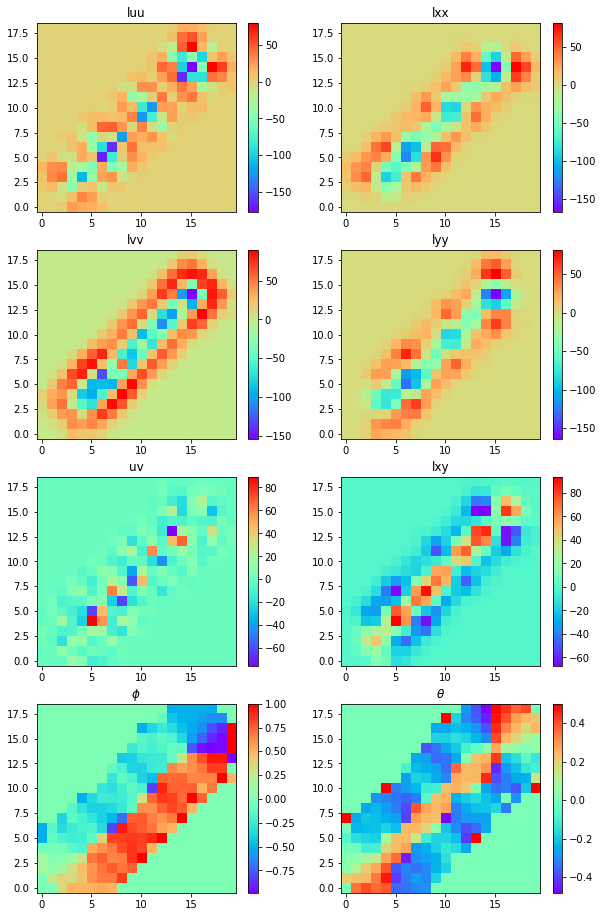

In [83]:
plt.figure(figsize = (2 * 5, 4 * 4))

plt.subplot(4, 2, 1)
plt.imshow(luu.T, origin = 'lower');
plt.colorbar();
plt.title('luu')
plt.subplot(4, 2, 2)
plt.imshow(lxx.T, origin = 'lower');
plt.title('lxx')
plt.colorbar();

plt.subplot(4, 2, 3)
plt.imshow(lvv.T, origin = 'lower');
plt.colorbar();
plt.title('lvv');
plt.subplot(4, 2, 4)
plt.imshow(lyy.T, origin = 'lower');
plt.colorbar();
plt.title('lyy');

plt.subplot(4, 2, 5)
plt.imshow(luv.T, origin = 'lower');
plt.colorbar();
plt.title('uv');
plt.subplot(4, 2, 6)
plt.imshow(lxy.T, origin = 'lower');
plt.colorbar();
plt.title('lxy');


plt.subplot(4, 2, 7)
plt.imshow(phi.T, origin = 'lower');
plt.colorbar();
plt.title(r'$\phi$');
plt.subplot(4, 2, 8)
plt.imshow(theta.T, origin = 'lower');
plt.colorbar();
plt.title(r'$\theta$');



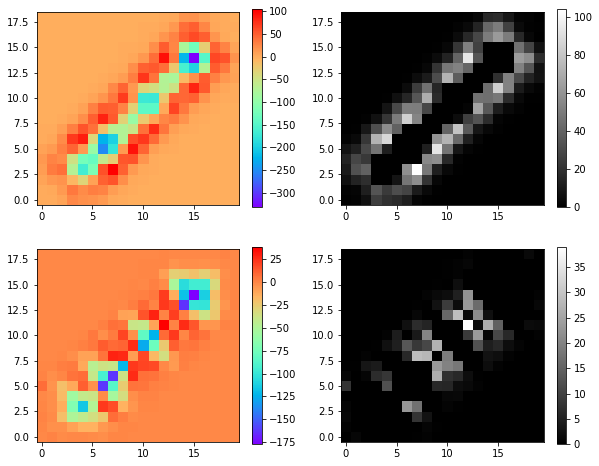

In [119]:

plt.figure(figsize = (2 * 5, 2 * 4))
disp = lap 
plt.subplot(2, 2, 1)
plt.imshow(disp.T, origin = 'lower');
plt.colorbar();
plt.subplot(2, 2, 2)
dd = np.copy(disp)
dd[disp < 0] = 0
plt.imshow(dd.T, origin = 'lower', cmap = 'gray');
plt.colorbar();

disp = lap - lvv
plt.subplot(2, 2, 3)
plt.imshow(disp.T, origin = 'lower');
plt.colorbar();
plt.subplot(2, 2, 4)
dd = np.copy(disp)
dd[disp < 0] = 0
plt.imshow(dd.T, origin = 'lower', cmap = 'gray');
plt.colorbar();

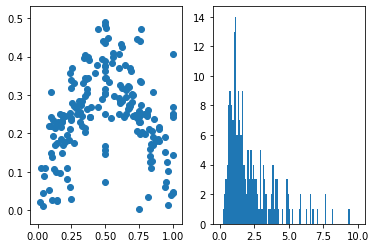

In [105]:
sel = (phi != 0) & (theta != 0)
plt.subplot(1, 2, 1)
plt.scatter(abs(phi[sel]), abs(theta[sel]), alpha = 1.);
plt.subplot(1, 2, 2)
plt.hist(abs(phi[sel].flatten())/abs(theta[sel].flatten()), 100, (0., 10.), alpha = 1.);

### Identify the edges

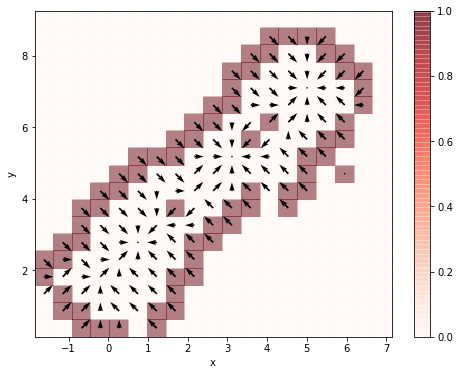

In [48]:
csel_ = pltclouds._csel
isel = ngrad == 1
plt.figure(figsize = (1 * 8, 1 * 6))
plt.hist2d(*csel_(cells, isel), bins = bins, weights = ngrad[isel], cmap = 'Reds', alpha = 0.5);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
pltclouds.dcloud_grad(cells, epath)

### Relation with the border between nodes areas

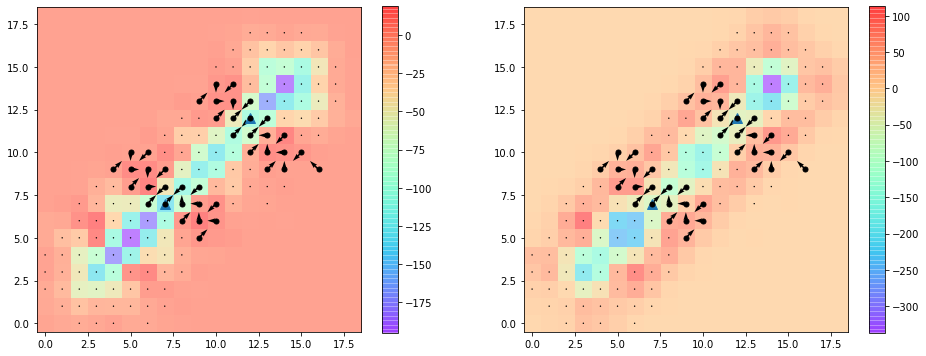

In [51]:
nodes, enodes, _    = clouds.clouds_nodes(enes, kids, epath)
lgrad, lnode, lpath = clouds.clouds_gradient_link(bins, cells, enes, nodes, kids)
epass  = clouds.clouds_passes(enes, nodes, enodes, lnode, kids, lgrad, lpath)

plt.figure(figsize = (2 * 8, 1 * 6))
plt.subplot(1, 2, 1)
pltclouds.dcloud_grad (icells, lpath)
plt.imshow(imin.T, origin = 'lower', alpha = 0.5);
isel   = epass > 0
plt.plot(*csel_(icells, isel), marker = '^', ls = '', ms = 10)
isel = (lnode > 0) & (nodes != lnode)
plt.plot(*csel_(icells, isel), marker = 'o', color ='black', ls = '', ms = 5)
plt.colorbar();

plt.subplot(1, 2, 2)
pltclouds.dcloud_grad (icells, lpath)
plt.imshow(lap.T, origin = 'lower', alpha = 0.5);
isel   = epass > 0
plt.plot(*csel_(icells, isel), marker = '^', ls = '', ms = 10)
isel = (lnode > 0) & (nodes != lnode)
plt.plot(*csel_(icells, isel), marker = 'o', color ='black', ls = '', ms = 5)
plt.colorbar();

In [25]:
isel = epass > 0
print(imin[csel_(icells, isel)])
isel = (lnode > 0) & (nodes != lnode)
print(sorted(imin[csel_(icells, isel)]))
print(sorted(enes[isel], reverse = True))


[-133.32744629 -112.201032   -108.83119928]
[-147.54602497034324, -133.32744629240656, -117.1246117974981, -112.2010320008075, -112.02293669387583, -108.83119928212756, -101.55818390547313, -98.38098116582543, -97.49863882502507, -94.01733872345795, -79.18248178132873, -78.8313880180138, -76.78318588130524, -74.84616673540357, -47.779596042886794, -47.537444622632854, -41.280469689717236, -41.117678248358665, -36.348451113597314, -34.86895947079003, -29.176092549471612, -28.972561132633885, -24.958581617111157, -24.895270444413484, -18.90591968177722, -16.947560814373265, -10.661658867804164, -10.489194648009097, -8.972383279960418, -3.3311401989875637, -3.1642542940774163, -1.5990195135927845, -0.7232732302827376, 0.0, 0.5409226330035715, 1.0204697822540183, 1.3336550884516711, 1.513893178231143, 1.5220731536503536, 3.6749901419573696, 4.482563795743609, 4.661165235168156, 4.797896149163076, 5.192063131067002, 6.720035913858332, 6.735821305967786, 9.261783012343034, 10.076159069094864

**Note**:

   * The pass is NOT the point with the largest negative curvature, but veru close.
   
   * Accept only passes with negative large curvature. 

### Clouds

In [26]:
df = clouds.clouds(coors, steps, ones)

{'cells': True, 'gradients': False, 'nodes': True, 'links': False, 'passes': False, 'segments': False, 'tracks': False, 'crests': True}


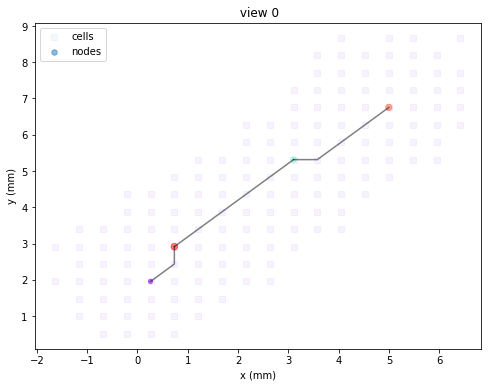

In [27]:
draw, plots = pltclouds.get_draw_clouds(df)
print(plots)
draw(plots, scale = 0.01)

### Dispersion in the ortoganal gradient direction